
# Generating geometric median composites (geomedians)

## NOTE: modified for PNG on EASI ASIA, original notebook [**here**](https://docs.dea.ga.gov.au/notebooks/Frequently_used_code/Generating_geomedian_composites.html)


## Background

Individual remote sensing images can be affected by noisy data, including clouds, cloud shadows, and haze. 
To produce cleaner images that can be compared more easily across time, we can create 'summary' images or 'composites' that combine multiple images into one image to reveal the median or 'typical' appearance of the landscape for a certain time period. 

One approach is to create a [geomedian](https://github.com/daleroberts/hdmedians). 
A `geomedian` is based on a high-dimensional statistic called the 'geometric median' [(Small 1990)](https://www.jstor.org/stable/1403809), which effectively trades a temporal stack of poor quality observations for a single high-quality pixel composite with reduced spatial noise [(Roberts et al. 2017)](https://ieeexplore.ieee.org/abstract/document/8004469). 
In contrast to a standard median, a geomedian maintains the relationship between spectral bands. 
This allows us to conduct further analysis on the composite images just as we would on the original satellite images (e.g by allowing the calculation of common band indices like NDVI).

## Description
In this notebook we will take of time series of noisy satellite images collected over a year and calculate an annual geomedian composite which is largely free of clouds and other noisy data.

Geomedian computations are expensive in terms of memory, data bandwidth, and cpu usage. 
The ODC has some useful functions, [int_geomedian](https://github.com/opendatacube/odc-tools/blob/master/libs/algo/odc/algo/_geomedian.py) and [xr_geomedian](https://github.com/opendatacube/odc-tools/blob/master/libs/algo/odc/algo/_geomedian.py) that allow [dask](https://docs.dask.org/en/latest/) to perform the computation in parallel across many threads to speed things up.  

In this notebook a local dask cluster is used, but the same approach should work using a larger, distributed dask cluster.  

**Notes**
- we use xr_geomedian as scaling and offset applied here for landsat data

***


#### Load packages

In [11]:
%matplotlib inline
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import os, sys
# sys.path.insert(1, "/home/jovyan/code/dea-notebooks/Tools")
import datacube
from datacube.utils import masking  # https://github.com/opendatacube/datacube-core/blob/develop/datacube/utils/masking.py
from datacube.utils.cog import write_cog
from odc.algo import to_f32, xr_geomedian, int_geomedian

from dea_tools.datahandling import load_ard
from dea_tools.plotting import rgb, display_map

from datacube.drivers.netcdf import write_dataset_to_netcdf

dc = datacube.Datacube(app='Generating_geomedian_composites')

#### Set up a dask cluster

In [12]:
from dask_gateway import Gateway

def init_dask_cluster() -> tuple:
    """Connect to an existing or start a new dask gateway cluster.
    Return (cluster, client)
    """
    gateway = Gateway()
    clusters = gateway.list_clusters()
    if not clusters:
        print('Creating new cluster. Please wait for this to finish.')
        cluster = gateway.new_cluster()
    else:
        print(f'An existing cluster was found. Connecting to: {clusters[0].name}')
        cluster=gateway.connect(clusters[0].name)
    cluster.adapt(minimum=1, maximum=4)  # A default starting point
    client = cluster.get_client()

    return (cluster, client)

cluster, client = init_dask_cluster()
display(cluster)

Creating new cluster. Please wait for this to finish.


#### AWS Access

In [13]:
## Optional: Access AWS "requester-pays" buckets
# This is necessary for Landsat ("landsatN_c2l2_*") and Sentinel-2 ("s2_l2a") products
from datacube.utils.aws import configure_s3_access
configure_s3_access(aws_unsigned=False, requester_pays=True, client=client);

#### display AOI

In [14]:
latitude = (-7.3, -7.4)
longitude = (144.4, 144.5)
display_map(longitude, latitude)

#### Load landsat data

In [15]:
# set time range
time = ('2020-01-01', '2020-12-31')

# load data
ds = dc.load(
    product = 'landsat8_c2l2_sr', 
    latitude = latitude,
    longitude = longitude,
    time=time,
    measurements=['blue', 'green', 'red', 'nir08', 'swir16', 'swir22', 'qa_pixel'],
    output_crs="EPSG:32755",  # Target CRS - https://epsg.io/?q=Papua%20New%20Guinea%20kind%3APROJCRS
    resolution=(30, -30),     # Target resolution
    group_by='solar_day',     # Group by time method
    dask_chunks={'time': 1, 'x': 100, 'y': 100}
)

# rename bands, needed for rgb function and for xr_geomedian
ds = ds.rename({
    "blue": "nbart_blue",
    "green": "nbart_green",
    "red": "nbart_red",
    "nir08": "nbart_nir",
    "swir16": "nbart_swir_1",
    "swir22": "nbart_swir_2",
    "qa_pixel": "fmask",
})

#### Plot timesteps in true colour (optional)
- This step can be quite slow because the dask arrays being plotted must be computed first.

In [16]:
# # Generate RGB plots at each timestep
# rgb(ds, col="time", robust=True, col_wrap=4)

#### scale data (required for col 2 landsat) and mask cloudy data
https://www.usgs.gov/faqs/how-do-i-use-scale-factor-landsat-level-2-science-products

In [17]:
# Make a mask array for the nodata value
valid_mask = masking.valid_data_mask(ds)

# Define the scaling values (landsat8_c2l2_sr)
scale_factor = 0.0000275
add_offset = -0.2

# Make a scaled data array
# scaled_data = ds * scale_factor + add_offset
scaled_data = to_f32(ds,
                   scale=scale_factor,
                   offset=add_offset)

#### could also make threshold for here for use of data array depending on cloud cover (i.e. data array must have >50% clear pixels)
- look here for details https://github.com/csiro-easi/eocsi-hackathon-2022/blob/main/case-studies/Change_detection.ipynb

In [18]:
# Make a cloud mask (landsat8_c2l2_sr)

# Multiple flags are combined as logical AND (bitwise)
cloud_mask = masking.make_mask(ds['fmask'], 
    clear='clear',
)
# Apply each of the masks
filtered_data = scaled_data.where(valid_mask & cloud_mask)

#### Generate Geomedian on float arrays

The ODC has a useful function, [xr_geomedian](https://github.com/opendatacube/odc-tools/blob/master/libs/algo/odc/algo/_geomedian.py) that allows for calcuating geomedians on a `xarray.Dataset` (as well as `xr.DataArrays` and `numpy` arrays) with a `float` datatype.

In [19]:
%%time
geomedian = xr_geomedian(filtered_data,
                         num_threads=1, # Setting num_thread=1 will disable the internal threading and instead allow parallelisation with dask.
                         eps=1e-7, # The eps parameter controls the number of iterations to conduct; a good default is 1e-7.
                         ).compute()

CPU times: user 1.73 s, sys: 36.2 ms, total: 1.76 s
Wall time: 1min 42s


In [20]:
geomedian

<xarray.Dataset>
Dimensions:       (y: 372, x: 371)
Coordinates:
  * y             (y) float64 9.181e+06 9.181e+06 ... 9.192e+06 9.192e+06
  * x             (x) float64 2.24e+05 2.24e+05 2.24e+05 ... 2.13e+05 2.129e+05
Data variables:
    nbart_blue    (y, x) float32 0.01914 0.02063 0.02116 ... 0.02815 0.02584
    nbart_green   (y, x) float32 0.04772 0.04659 0.05001 ... 0.05936 0.05669
    nbart_red     (y, x) float32 0.03395 0.03208 0.03645 ... 0.03698 0.03468
    nbart_nir     (y, x) float32 0.3158 0.3198 0.2974 ... 0.3948 0.3852 0.3627
    nbart_swir_1  (y, x) float32 0.09704 0.09519 0.09746 ... 0.1474 0.1456 0.143
    nbart_swir_2  (y, x) float32 0.03011 0.03146 0.04112 ... 0.05926 0.05881
    fmask         (y, x) float32 0.401 0.4067 0.4408 ... 0.4002 0.4002 0.406

### Plot the geomedian composite

Plotting the result, we can see that the geomedian image is much more complete than any of the individual images. 
We can also use this data in downstream analysis as the relationships between the spectral bands are maintained by the geometric median statistic.


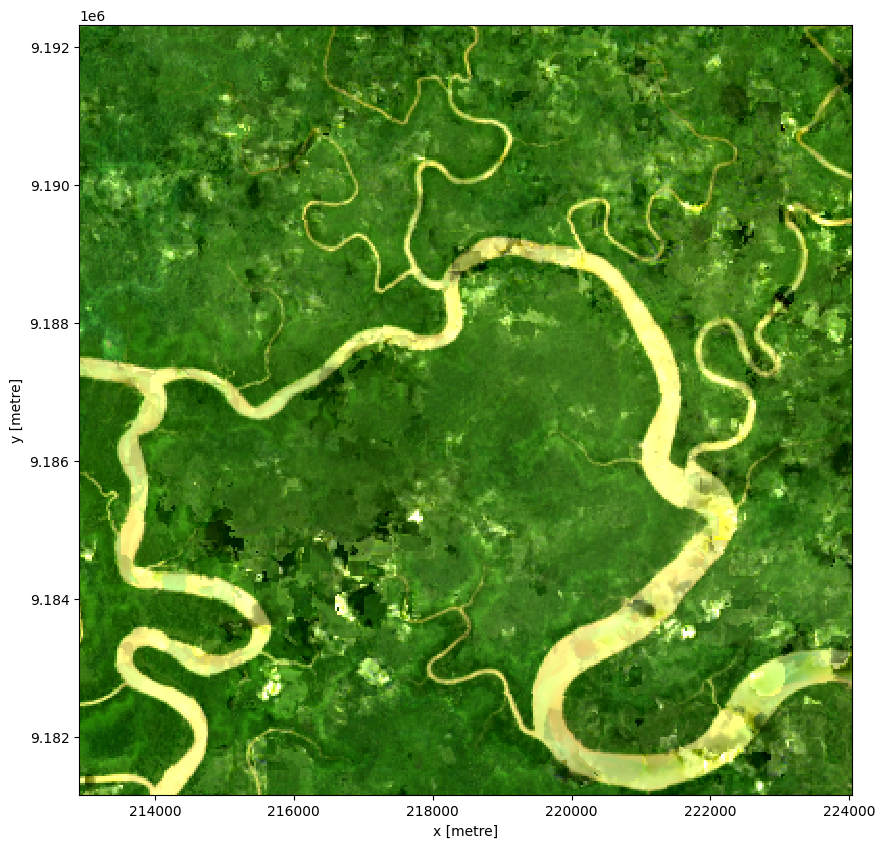

In [21]:
# Plot the result
rgb(geomedian, size=10)

In [23]:
# add crs and to_array for cog output
geomedian.attrs['crs'] = 'EPSG:32755'
geomedian_export = geomedian.to_array()

# output as cog
write_cog(geomedian_export, '../data/geomedian_test.tif', overwrite=True)

# export out as .nc to allow load back in easily as xarray
write_dataset_to_netcdf(geomedian, '../data/geomedian_test.nc')